In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from MotionBERT.common_import import *

### Load Dataset

In [2]:
data_type_list = [
    'source_list', 'cam_param',
    'cam_3d', 'img_2d',
    'cam_3d_canonical_revolute', 'img_2d_canonical_revolute',
    #'img_3d', 'scale_factor', 'img_25d'
]
overwrite_list = []
dataset_name = 'h36m'
data_aug = default_data_aug.copy()
data = load_data_dict(dataset_name, data_type_list, overwrite_list, verbose=True, data_aug=data_aug)

[overwrite: False] ==> Loading H36M source_list...
[overwrite: False] ==> Loading H36M cam_param...
[overwrite: False] ==> Loading H36M cam_3d...
[overwrite: False] ==> Loading H36M img_2d...
[overwrite: False] ==> Loading H36M cam_3d_canonical_revolute...
[overwrite: False] ==> Loading H36M img_2d_canonical_revolute...


In [7]:
source_list = data['source_list'].copy()
subject, cam_id, action = split_source_name(source_list[0], dataset_name)

# camera parameters
cam_param = data['cam_param'][subject][action][cam_id].copy()
W, H, intrinsic = cam_param['W'], cam_param['H'], cam_param['intrinsic']
fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]
inv_intrinsic = np.linalg.inv(intrinsic)

cam_3d_canonical_revolute = data['cam_3d_canonical_revolute'][subject][action][cam_id].copy()
cam_3d_canonical_revolute_hat = cam_3d_canonical_revolute.copy() - cam_3d_canonical_revolute[:, 0, None]
img_2d_canonical_revolute = data['img_2d_canonical_revolute'][subject][action][cam_id].copy()
img_2d_canonical_revolute_centered = img_2d_canonical_revolute.copy() - img_2d_canonical_revolute[:, 0, None] + [W//2, H//2]
img_2d_canonical_revolute_norm = normalize_input(img_2d_canonical_revolute, W, H)
img_2d_canonical_revolute_norm_centered = img_2d_canonical_revolute_norm.copy() - img_2d_canonical_revolute_norm[:, 0, None]
# homogeneous coordinates
f, j, c = img_2d_canonical_revolute.shape
img_2d_canonical_revolute_homo = np.concatenate([img_2d_canonical_revolute, np.ones([f, j, 1])], axis=-1)

img_2d_canonical_revolute_norm_plane = np.einsum('fjc,ck->fjk', img_2d_canonical_revolute_homo, inv_intrinsic.T)[..., :2]

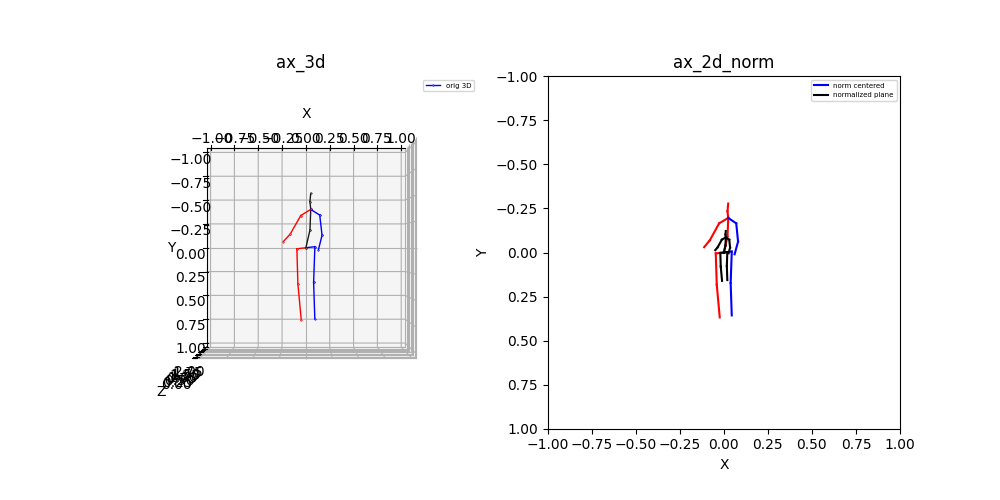

In [4]:
%matplotlib widget
# check original train data
frame_num = 0
configs = {
    'ax_3d': {'type': '3d', 'loc': 121, 'mode': 'cam', 'xlim': [-1, 1], 'ylim': [-1, 1], 'zlim': [0, 2]},
    #'ax_2d': {'type': '2d', 'loc': 122, 'W': W, 'H': H},
    'ax_2d_norm': {'type': '2d', 'loc': 122, 'normalize': True},
}

fig, axs = generate_axes(0, configs, figsize=[10, 5], fig_title='')
plot_pose_setting = [
    ('ax_3d', cam_3d_canonical_revolute, {'color': '', 'label': 'orig 3D'}),
    #('ax_2d', img_2d_canonical_revolute, {'color': '', 'label': 'orig 2D'}),
    ('ax_2d_norm', img_2d_canonical_revolute_norm_centered, {'color': '', 'label': 'norm centered'}),
    ('ax_2d_norm', img_2d_canonical_revolute_norm_plane, {'color': 'k', 'label': 'normalized plane'})
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

### img_3d_canonical_revolute

In [19]:
def draw_line_through_points(ax, x1, y1, x2, y2, x_range=(-1, 1), num_points=400):
    """
    두 점 (x1, y1)과 (x2, y2)을 지나는 직선을 그리는 함수.
    수직선(x1 == x2)도 지원함.
    
    Parameters:
    - x1, y1, x2, y2: 두 점의 좌표
    - x_range: 그래프에서 x축의 범위 (기본값: -10 ~ 10)
    - num_points: x 값 개수 (기본값: 400)
    """

    if x1 == x2:
        # 수직선 처리 (x가 고정된 직선)
        x_vals = np.full(num_points, x1)  # x1 값을 num_points 개만큼 반복
        y_vals = np.linspace(x_range[0], x_range[1], num_points)  # y 값은 넓은 범위에서 설정
    else:
        # 기울기와 y절편 계산
        m = (y2 - y1) / (x2 - x1)  # 기울기
        b = y1 - m * x1            # y절편

        # 넓은 x 범위에서 직선 생성
        x_vals = np.linspace(x_range[0], x_range[1], num_points)
        y_vals = m * x_vals + b

    # 직선 그리기
    ax.plot(x_vals, y_vals, 'y--', linewidth=0.5, label="직선")
    ax.scatter([x1, x2], [y1, y2], color='blue', label="주어진 두 점")

    return ax

In [7]:
cam_3d = cam_3d_canonical_revolute.copy()
img_2d_norm_centered = img_2d_canonical_revolute_norm_centered.copy()
img_3d_norm, scale_ratio_3d_to_2d = generate_img_3d(cam_3d, img_2d_norm_centered)
img_3d_norm_xy = img_3d_norm[..., :2].copy()
img_3d_norm_hat = img_3d_norm - img_3d_norm[:, 0, None]
img_3d = denormalize_input(img_3d_norm, W, H)
img_3d_xy = img_3d[..., :2].copy()
img_3d_hat = img_3d - img_3d[:, 0, None] + [W//2, H//2, 0]
img_25d_hat = img_3d_norm_hat / scale_ratio_3d_to_2d[:, None, None]

scale_ratio_3d_to_2d: [0.40956871 0.40956998 0.40960129 ... 0.40493678 0.40488986 0.40484815]


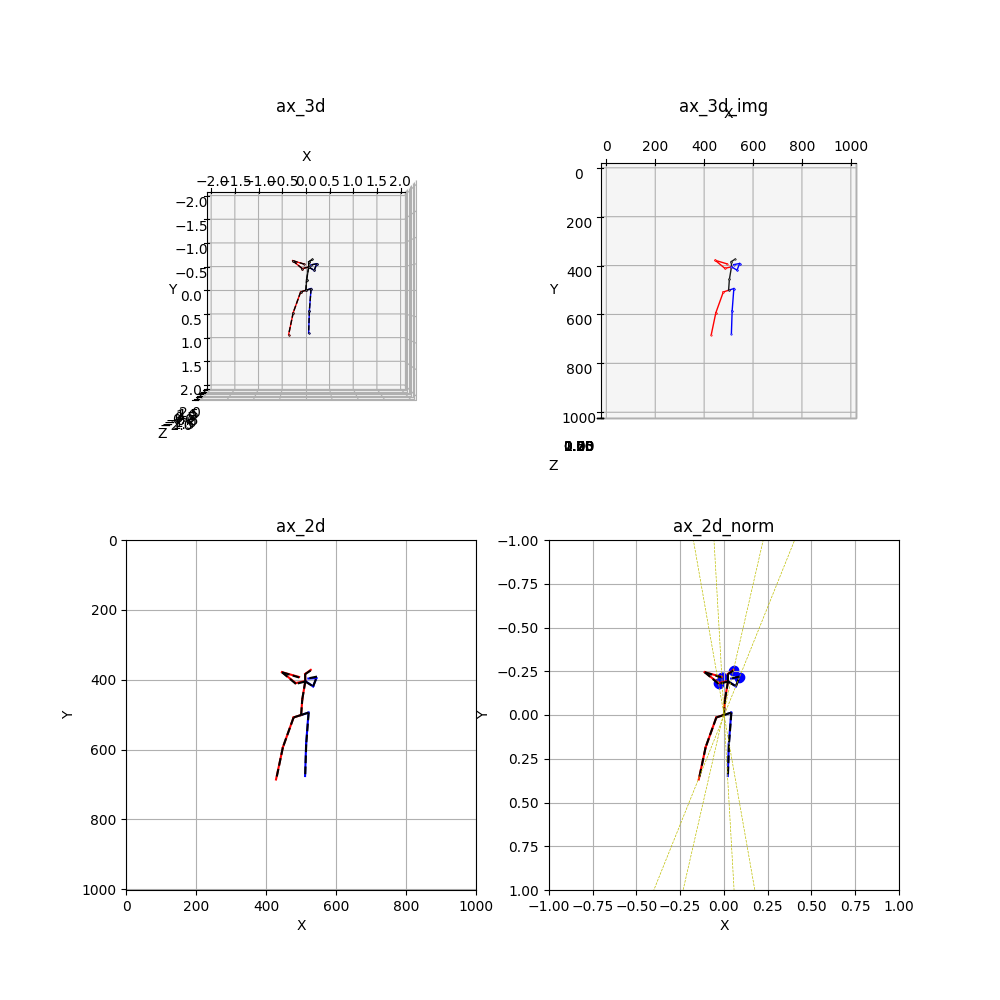

In [9]:
%matplotlib widget
frame_num = 1000
configs = {
    'ax_3d': {'type': '3d', 'loc': 221, 'mode': 'cam'},
    'ax_3d_img': {'type': '3d', 'loc': 222, 'mode': 'cam', 'xlim': [0, W], 'ylim': [0, H], 'zlim': [0, 2]},
    'ax_2d': {'type': '2d', 'loc': 223, 'W': W, 'H': H},
    'ax_2d_norm': {'type': '2d', 'loc': 224, 'normalize': True},
}

fig, axs = generate_axes(1, configs, figsize=[10, 10], fig_title='')
plot_pose_setting = [
    ('ax_3d', cam_3d_canonical_revolute_hat,        {'color': '', 'label': ''}),
    ('ax_3d', img_25d_hat,                          {'color': 'k', 'linestyle': '--', 'label': ''}),
    ('ax_3d_img', img_3d_hat,                       {'color': '', 'label': ''}),
    ('ax_2d', img_2d_canonical_revolute_centered,   {'color': '', 'label': ''}),
    ('ax_2d', img_3d_xy,                            {'color': 'k', 'linestyle': '--', 'label': ''}),
    ('ax_2d_norm', img_2d_norm_centered,            {'color': '', 'label': ''}),
    ('ax_2d_norm', img_3d_norm_xy,                  {'color': 'k', 'linestyle': '--', 'label': ''}),
]
axs['ax_2d_norm'].grid(True)

general_plot_func(axs, configs, plot_pose_setting, frame_num)
axs['ax_2d'].grid(True)

# draw line
for key in ['R_elbow', 'L_shoulder', 'L_wrist', 'Head']:
    joint_idx = get_h36m_keypoint_index(key)
    point1 = img_2d_norm_centered[frame_num, joint_idx]
    point2 = img_3d_norm_xy[frame_num, joint_idx]
    axs['ax_2d_norm'] = draw_line_through_points(axs['ax_2d_norm'], point1[0], point1[1], point2[0], point2[1])

plt.show()

In [4]:
### verify laod data
data_type_list = [
    'source_list', 'cam_param',
    'img_3d_norm', 'scale_ratio_3d_to_2d',
    'cam_3d', 'img_2d',
    'cam_3d_canonical_revolute', 'img_2d_canonical_revolute',
]
overwrite_list = []
dataset_name = 'h36m'
data_aug = default_data_aug.copy()
data = load_data_dict(dataset_name, data_type_list, overwrite_list, verbose=True, data_aug=data_aug)

[overwrite: False] ==> Loading H36M source_list...
[overwrite: False] ==> Loading H36M cam_param...
[overwrite: False] ==> Loading H36M img_3d_norm...
[overwrite: False] ==> Loading H36M scale_ratio_3d_to_2d...
[overwrite: False] ==> Loading H36M cam_3d...
[overwrite: False] ==> Loading H36M img_2d...
[overwrite: False] ==> Loading H36M cam_3d_canonical_revolute...
[overwrite: False] ==> Loading H36M img_2d_canonical_revolute...


In [5]:
source_list = data['source_list'].copy()
subject, cam_id, action = split_source_name(source_list[0], dataset_name)

# camera parameters
cam_param = data['cam_param'][subject][action][cam_id].copy()
W, H = cam_param['W'], cam_param['H']

img_3d_norm = data['img_3d_norm'][subject][action][cam_id].copy()
scale_ratio_3d_to_2d = data['scale_ratio_3d_to_2d'][subject][action][cam_id].copy()
cam_3d_canonical_revolute = data['cam_3d_canonical_revolute'][subject][action][cam_id].copy()
img_2d_canonical_revolute = data['img_2d_canonical_revolute'][subject][action][cam_id].copy()

cam_3d_canonical_revolute_hat = cam_3d_canonical_revolute.copy() - cam_3d_canonical_revolute[:, 0, None]
img_2d_canonical_revolute_centered = img_2d_canonical_revolute.copy() - img_2d_canonical_revolute[:, 0, None] + [W//2, H//2]
img_2d_canonical_revolute_norm = normalize_input(img_2d_canonical_revolute, W, H)
img_2d_canonical_revolute_norm_centered = img_2d_canonical_revolute_norm.copy() - img_2d_canonical_revolute_norm[:, 0, None]

img_3d_norm_xy = img_3d_norm[..., :2].copy()
img_3d_norm_hat = img_3d_norm - img_3d_norm[:, 0, None]
img_3d = denormalize_input(img_3d_norm, W, H)
img_3d_xy = img_3d[..., :2].copy()
img_3d_hat = img_3d - img_3d[:, 0, None] + [W//2, H//2, 0]
img_25d_hat = img_3d_norm_hat / scale_ratio_3d_to_2d[:, None, None]

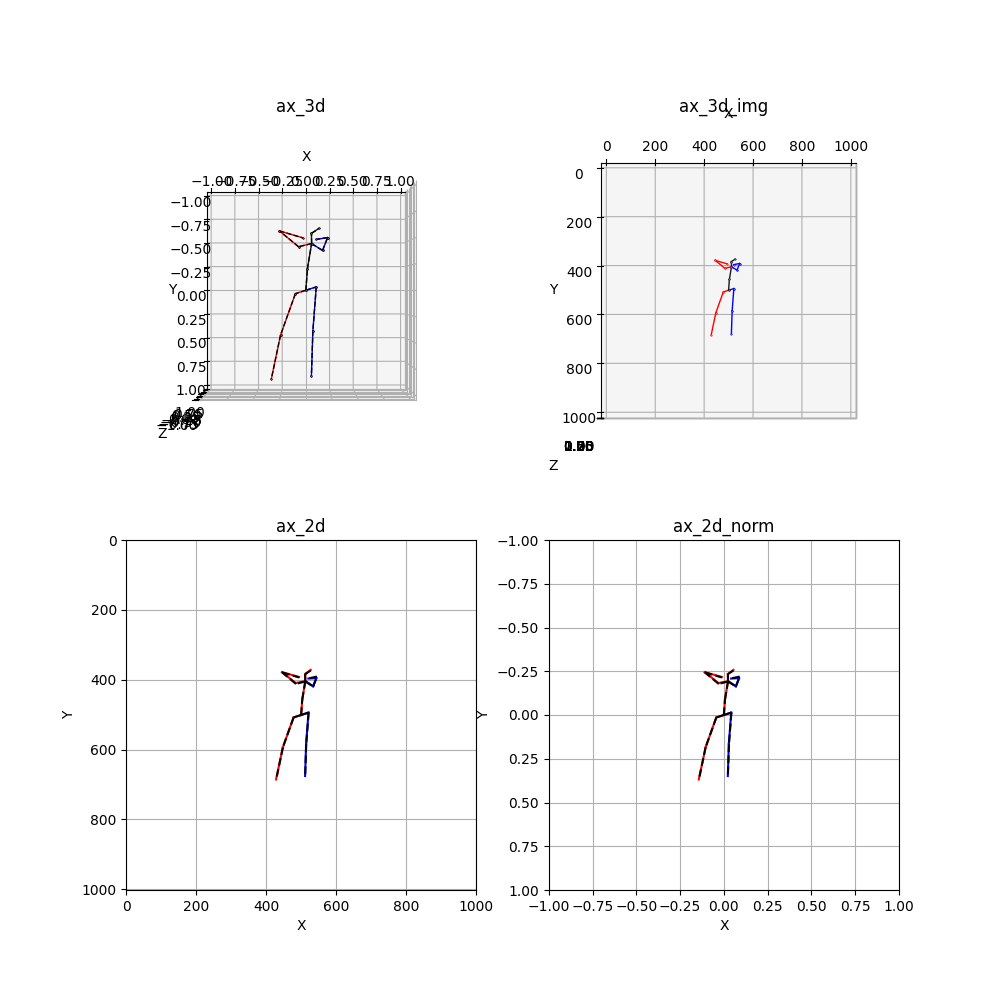

In [8]:
%matplotlib widget
frame_num = 1000
configs = {
    'ax_3d': {'type': '3d', 'loc': 221, 'mode': 'cam', 'xlim': [-1, 1], 'ylim': [-1, 1], 'zlim': [-1, 1]},
    'ax_3d_img': {'type': '3d', 'loc': 222, 'mode': 'cam', 'xlim': [0, W], 'ylim': [0, H], 'zlim': [0, 2]},
    'ax_2d': {'type': '2d', 'loc': 223, 'W': W, 'H': H},
    'ax_2d_norm': {'type': '2d', 'loc': 224, 'normalize': True},
}

fig, axs = generate_axes(2, configs, figsize=[10, 10], fig_title='')
plot_pose_setting = [
    ('ax_3d', cam_3d_canonical_revolute_hat,        {'color': '', 'label': ''}),
    ('ax_3d', img_25d_hat,                          {'color': 'k', 'linestyle': '--', 'label': ''}),
    #('ax_3d', img_3d_norm,                       {'color': 'k', 'linestyle': '--', 'label': ''}),
    ('ax_3d_img', img_3d_hat,                       {'color': '', 'label': ''}),
    ('ax_2d', img_2d_canonical_revolute_centered,   {'color': '', 'label': ''}),
    ('ax_2d', img_3d_xy,                            {'color': 'k', 'linestyle': '--', 'label': ''}),
    ('ax_2d_norm', img_2d_canonical_revolute_norm_centered,  {'color': '', 'label': ''}),
    ('ax_2d_norm', img_3d_norm_xy,                  {'color': 'k', 'linestyle': '--', 'label': ''}),
]
axs['ax_2d_norm'].grid(True)

general_plot_func(axs, configs, plot_pose_setting, frame_num)
axs['ax_2d'].grid(True)

# draw line
# for key in ['R_elbow', 'L_shoulder', 'L_wrist', 'Head']:
#     joint_idx = get_h36m_keypoint_index(key)
#     point1 = img_2d_canonical_revolute_norm_centered[frame_num, joint_idx]
#     point2 = img_3d_norm_xy[frame_num, joint_idx]
#     axs['ax_2d_norm'] = draw_line_through_points(axs['ax_2d_norm'], point1[0], point1[1], point2[0], point2[1])

plt.show()

### Length Ratio

In [7]:
### Define Parent Joint
parent_index = get_parent_index(17)
print(f"parent_index: {parent_index}")

# Verify
for i in range(17):
    print(f'{get_h36m_joint_name(i)}: {get_h36m_joint_name(parent_index[i])}')

parent_index: [0, 0, 1, 2, 0, 4, 5, 0, 7, 8, 9, 8, 11, 12, 8, 14, 15]
Pelvis: Pelvis
R_Hip: Pelvis
R_Knee: R_Hip
R_Ankle: R_Knee
L_Hip: Pelvis
L_Knee: L_Hip
L_Ankle: L_Knee
Torso: Pelvis
Neck: Torso
Nose: Neck
Head: Nose
L_Shoulder: Neck
L_Elbow: L_Shoulder
L_Wrist: L_Elbow
R_Shoulder: Neck
R_Elbow: R_Shoulder
R_Wrist: R_Elbow


In [8]:
### Define Length
length = get_length_from_pose3d(cam_3d_canonical_revolute)

In [14]:
# By pelvis length = left-right hip length
length_ratio = get_length_ratio_from_pose3d(cam_3d_canonical_revolute, 'pelvis')
print(length_ratio.std(axis=0), length_ratio[0])

# By parent length
length_ratio_parent = get_length_ratio_from_pose3d(cam_3d_canonical_revolute, 'parent')
print(length_ratio_parent.std(axis=0), length_ratio_parent[0])


[0.00000000e+00 4.24756232e-08 1.44918100e-07 1.26732870e-07
 4.24756232e-08 1.51630326e-07 1.21045871e-07 1.33974133e-05
 2.67125963e-07 1.94138286e-07 1.96914028e-07 1.08038449e-07
 1.94960598e-07 1.77080793e-07 1.33455825e-07 2.00571027e-07
 1.61875655e-07] [1.         0.49999958 1.66565968 1.70820177 0.50000042 1.6656588
 1.70820228 0.87805749 0.96683005 0.45557033 0.43250587 0.56801687
 1.04883611 0.9467313  0.5680063  1.04887396 0.94671359]
[0.00000000e+00 4.24756232e-08 4.62921667e-07 9.99231799e-08
 4.24756232e-08 3.39296238e-07 8.19183543e-08 1.33974133e-05
 1.68031119e-05 2.80351500e-07 7.04113809e-07 1.49262485e-07
 5.49403844e-07 2.51959907e-07 1.55340450e-07 6.32766539e-07
 2.39632797e-07] [1.         0.49999958 3.33132216 1.02554068 0.50000042 3.3313148
 1.02554153 0.87805749 1.10110108 0.47120002 0.94937232 0.58750436
 1.84648761 0.90264941 0.58749343 1.8465886  0.90259996]


In [17]:
length_ratio_pelvis = get_length_ratio_from_pose3d(cam_3d_canonical_revolute, base_length_type='pelvis') # (F, J)
length_ratio_parent = get_length_ratio_from_pose3d(cam_3d_canonical_revolute, base_length_type='parent') # (F, J)
scaled_length_ratio_pelvis = get_length_ratio_from_pose3d(img_3d_norm, base_length_type='pelvis') # (F, J)
scaled_length_ratio_parent = get_length_ratio_from_pose3d(img_3d_norm, base_length_type='parent') # (F, J)
np.abs(length_ratio_pelvis - scaled_length_ratio_pelvis).mean(), np.abs(length_ratio_parent - scaled_length_ratio_parent).mean()

(8.424225369573017e-16, 1.3044576312372734e-15)

### Relative Depth

In [18]:
relative_depth = get_root_relative_depth_from_pose(cam_3d_canonical_revolute) # (F, J)
relative_depth[0]

array([ 0.        ,  0.07174453,  0.07290993,  0.05803841, -0.07174464,
        0.01525881, -0.02568855, -0.06576799, -0.11013875, -0.03878663,
       -0.09479684, -0.15250406, -0.05356049,  0.16289708, -0.03419789,
        0.09046658,  0.26023398])